In [1]:
# import libraries
import os
from pyspark.sql.functions import *
from pyspark.sql.types import *
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import re
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import Window
from datetime import datetime, timedelta
from itertools import combinations, takewhile
import collections
import re
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pd.set_option('max_colwidth',1000)
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [ ]:
directory = 'gs://msca-bdp-tweets/Tweets/'
file = '*.json'
path = directory + file
%time tweets_df = spark.read.json(path)

CPU times: user 273 ms, sys: 109 ms, total: 382 ms
Wall time: 32min 10s


In [7]:
tweets_df.limit(1)

contributors,coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,limit,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,reply_count,retweet_count,retweeted,retweeted_status,scopes,source,text,timestamp_ms,truncated,user,withheld_copyright,withheld_in_countries
null,null,Wed May 16 18:15:...,null,"[[],, [], [[press...",null,null,0,false,low,null,996816307512213504,996816307512213504,null,null,null,null,null,false,en,null,null,false,0,null,null,null,null,0,0,false,null,null,"<a href=""https://...",University of Lou...,1526494502319,false,"[false, Wed Feb 1...",null,null


In [8]:
tweets_df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: bo

## Select certain columns

In [5]:
tweets_new_df = tweets_df.select(['created_at','id_str','text','user','place','quoted_status','retweeted_status','retweet_count','retweeted','favorite_count','favorited','entities'])

In [5]:
tweets_new_df.limit(1)

created_at,id_str,text,user,place,quoted_status,retweeted_status,retweet_count,retweeted,favorite_count,favorited,entities
Wed May 08 20:14:...,1126218952785502208,RT @simonctsays: ...,"[false, Fri Apr 1...",null,null,"[,, Wed May 08 04...",0,false,0,false,"[[], [[,, pic.twi..."


### Discard rows with no user information

In [6]:
tweets_new_df = tweets_new_df.filter(tweets_new_df.user.isNotNull())

### Extract user profile

In [7]:
# extracting user object
tweets_new_df = tweets_new_df.withColumn('user_id',col('user.id_str')).withColumn('user_followers_count',col('user.followers_count')).withColumn('user_friends_count',col('user.friends_count')).withColumn('user_listed_count',col('user.listed_count')).withColumn('user_location',col('user.location')).withColumn('user_name',col('user.name')).withColumn('user_statuses_count',col('user.statuses_count')).withColumn('user_verified',col('user.verified'))

In [7]:
tweets_new_df.limit(5)

created_at,id_str,text,user,place,quoted_status,retweeted_status,retweet_count,retweeted,favorite_count,favorited,entities,user_id,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_statuses_count,user_verified
Thu Mar 28 19:14:...,1111345949119533056,RT @chugi3: @Woma...,"[false, Fri Jul 1...",null,"[,, Thu Mar 28 15...","[,, Thu Mar 28 18...",0,false,0,false,"[[],, [], [], [[5...",1017564072244543488,780,1050,0,null,Amanda Shmiel,1473,false
Thu Mar 28 19:14:...,1111345950402985984,RT @BlitzProxies:...,"[false, Wed Nov 0...",null,null,"[,, Thu Mar 28 19...",0,false,0,false,"[[],, [], [], [[8...",2890284486,70,534,0,null,zTurtleblood,643,false
Thu Mar 28 19:14:...,1111345950528692225,@burtonlee @Noahp...,"[false, Mon Dec 0...",null,null,null,0,false,0,false,"[[],, [], [[twitt...",17973378,3183,816,187,"San Francisco, CA",Nick Pinkston 🌐,8259,false
Thu Mar 28 19:14:...,1111345951195561984,RT @ogie_rosa: Hi...,"[false, Sat Aug 2...",null,null,"[,, Wed Mar 27 22...",0,false,0,false,"[[],, [], [], [[7...",358834191,973,673,11,"Kassel, GER",Sabrina Chloe,41888,false
Thu Mar 28 19:14:...,1111345954207068166,"@HickettsG no, th...","[false, Sat Sep 1...",null,null,null,0,false,0,false,"[[],, [], [], [[1...",776958411149758464,584,930,7,Location,ⁿᵒ,9786,false


### Drop user column

In [8]:
tweets_new_df = tweets_new_df.drop('user')

### Extraxt information from user entities

In [9]:
#user_mentions
user_mentions_df = tweets_new_df.withColumn("user_mentions", explode("entities.user_mentions")).select("user_mentions.*")

# counting the no of mention
user_mentions_df = user_mentions_df.groupby('id_str').agg(count('id').alias('user_no_of_mentions'))

# changing column name
user_mentions_df = user_mentions_df.withColumn('user_id_m',col('id_str')).drop('id_str')

# adding user_no_of_mentions as column to main df
tweets_df_pruned = tweets_new_df.join(user_mentions_df, tweets_new_df.user_id == user_mentions_df.user_id_m,
                                         how='left').drop('user_id_m')

### Drop entities column

In [10]:
tweets_new_df = tweets_new_df.drop('entities')

## Identify tweets related to UChicago and 3-4 universities of your choice

## Discard irrelevant tweets

In [11]:
# UChicago, Harvard, Columbia, UPenn tweets
tweets_df_univ = tweets_new_df.filter(lower(col('text')).contains('uchicago') | lower(col('text')).contains('upenn') |lower(col('text')).contains('penn') |lower(col('text')).contains('university of chicago') | lower(col('text')).contains('harvard') |lower(col('text')).contains('harvard university') |lower(col('text')).contains('university of pennsylvania') | lower(col('text')).contains('columbia university'))

In [12]:
# tweets containing other topics
tweets_df_nonuniv = tweets_new_df.filter(~lower(col('text')).contains('university') & ~lower(col('text')).contains('uchicago') & ~lower(col('text')).contains('upenn') &~lower(col('text')).contains('penn') & ~lower(col('text')).contains('harvard'))

### UChicago tweets

In [13]:
#save uchicago tweets
tweets_df_uchicago = tweets_df_univ.filter(lower(col('text')).contains('uchicago') | lower(col('text')).contains('university of chicago'))

### Other universities

In [14]:
#save harvard tweets
tweets_df_harvard = tweets_df_univ.filter(lower(col('text')).contains('harvard') | lower(col('text')).contains('harvard university'))

#save columbia tweets
tweets_df_columbia = tweets_df_univ.filter(lower(col('text')).contains('columbia university'))

#save upenn tweets
tweets_df_upenn = tweets_df_univ.filter(lower(col('text')).contains('upenn') | lower(col('text')).contains('penn') | lower(col('text')).contains('university of pennsylvania'))

## Complete thorough EDA to identify which variables you can use to profile the Twitterers

In [16]:
tweets_df_univ.columns

['created_at',
 'id_str',
 'text',
 'place',
 'quoted_status',
 'retweeted_status',
 'retweet_count',
 'retweeted',
 'favorite_count',
 'favorited',
 'user_id',
 'user_followers_count',
 'user_friends_count',
 'user_listed_count',
 'user_location',
 'user_name',
 'user_statuses_count',
 'user_verified',
 'user_no_of_mentions']

In [17]:
tweets_df_univ.filter('retweet_count!=0').count()

0

**Discard retweet count column**

In [18]:
tweets_df_univ.filter('favorite_count!=0').count()

0

**Discard favourite count column**

In [43]:
tweets_df_univ.filter('retweeted!="false"').count()

0

**Discard retweeted column**

In [19]:
tweets_df_univ.filter(col('retweeted_status').isNull()).count()

1752380

**Use retweeted status column**

In [45]:
tweets_df_univ.filter('favorited!="false"').count()

0

**Discard favourited column**

In [20]:
tweets_df_univ.filter('user_followers_count==0').count()

58160

**Use user_followers_count column**

In [21]:
tweets_df_univ.filter('user_friends_count==0').count()

48023

**Use user_friends_count column**

In [22]:
tweets_df_univ.filter('user_listed_count==0').count()

2013853

**Use user_listed_count column**

In [49]:
tweets_df_univ.filter('user_statuses_count==0').count()

0

**Use user_statuses_count column**

In [23]:
tweets_df_univ.filter('user_verified=="true"').count()

129220

**Use user_verified column**

In [16]:
tweets_df_univ.filter(col('user_no_of_mentions').isNull()).count()

2437161

**Use user_no_of_mentions column**

## Identify the most prolific / influential Twitterers
- By message volume
- By message retweet
- How much are they tweeting about the Universities vs. other topics?

In [15]:
# university
influencers_univ_df = tweets_df_univ.filter(col('retweeted_status').isNull()).\
                                               groupBy(['user_id','user_name']).agg(count('id_str').\
                                               alias('original_tweet_count_univ')).\
                                               orderBy('original_tweet_count_univ',ascending=False).limit(5)
influencers_univ_df

user_id,user_name,original_tweet_count_univ
880005795974217728,Christina Masden,6822
922789731049521158,Jay,3349
884786387815452672,Healthcare Status,3072
887326002879373313,Economic Sector,2714
20270494,UChicago Athletics,2645


**Christina Madsen is the most influencial person with highest tweet count**

### By message retweet

In [16]:
influencers_univ_df_retweet = tweets_df_univ.select(['retweeted_status.user.id_str',
                                                       'retweeted_status.user.name',
                                                       'retweeted_status.retweet_count']).\
                          withColumnRenamed('id_str','user_id').\
                          withColumnRenamed('name','user_name').\
                          groupBy(['user_id','user_name']).\
                          agg(round(mean('retweet_count')).cast('integer').alias('mean_retweet_count')).\
                          orderBy('mean_retweet_count',ascending=False).limit(5)

influencers_univ_df_retweet

user_id,user_name,mean_retweet_count
3727024512,Air•ten,172903
3727024512,Air•ten 🌞,169393
3727024512,A pimp named slic...,165078
3727024512,air•ten,164040
3727024512,Chukwuayrton,162906


**Air.ten is the most influencial user by average retweet count**

In [17]:
tweets_df_nonuniv.filter(col('user_id').contains(influencers_univ_df_retweet.select(['user_id']).toPandas().iloc[0].values[0])).\
groupBy(['user_id','user_name']).agg(count('id_str').\
alias('tweet_count_other_topics'))

user_id,user_name,tweet_count_other_topics
3727024512,Ayrton Little,1
3727024512,Tha Little Man,10
3727024512,BLM,1
3727024512,Air•ten 🌞,1
3727024512,Air•ten,1


**Ayrton Little is the most influencial user in the non-university section**

## Where are these Twitterers located?
- For UChicago
- For other universities
- Do you see any relationship between university locations and Twitterers’ locations?
- Visualize the relationships

### UChicago

In [15]:
# uchicago users locations
tweets_df_uchicago_userloc = tweets_df_uchicago.filter(col('user_location').isNotNull()).\
groupBy(['user_location']).\
agg(count('user_id').alias('total_users_located')).\
orderBy('total_users_located',ascending=False).limit(5).toPandas()

tweets_df_uchicago_userloc

,user_location,total_users_located
0,"Chicago, IL",66940
1,Chicago,19990
2,"Chicago, Illinois",10150
3,United States,10047
4,"Washington, DC",6236


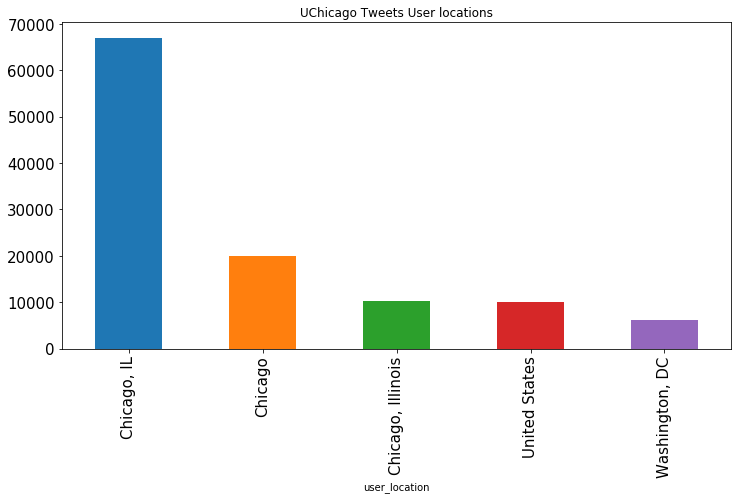

In [17]:
my_plot = tweets_df_uchicago_userloc.plot(kind='bar',x='user_location', y='total_users_located', 
                                   legend=None, title="UChicago Tweets User locations",
                                   figsize=(12,6),fontsize=15)

### Columbia University

In [19]:
# Columbia users locations
tweets_df_columbia_userloc = tweets_df_columbia.filter(col('user_location').isNotNull()).\
groupBy(['user_location']).\
agg(count('user_id').alias('total_users_located')).orderBy('total_users_located',ascending=False).limit(5).toPandas()

tweets_df_columbia_userloc

,user_location,total_users_located
0,United States,14245
1,"New York, NY",12226
2,USA,5051
3,"California, USA",4357
4,India,4093


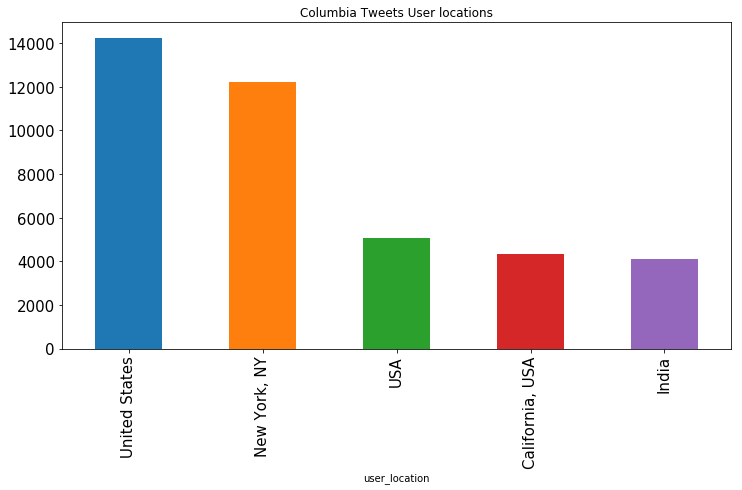

In [21]:
my_plot = tweets_df_columbia_userloc.plot(kind='bar',x='user_location', y='total_users_located', 
                                   legend=None, title="Columbia Tweets User locations",
                                   figsize=(12,6),fontsize=15)

### Harvard University

In [23]:
# Harvard users locations
tweets_df_harvard_userloc = tweets_df_harvard.filter(col('user_location').isNotNull()).\
groupBy(['user_location']).\
agg(count('user_id').alias('total_users_located')).orderBy('total_users_located',ascending=False).limit(5).toPandas()

tweets_df_harvard_userloc

,user_location,total_users_located
0,United States,91353
1,"Boston, MA",33963
2,India,32152
3,USA,31327
4,"Cambridge, MA",29249


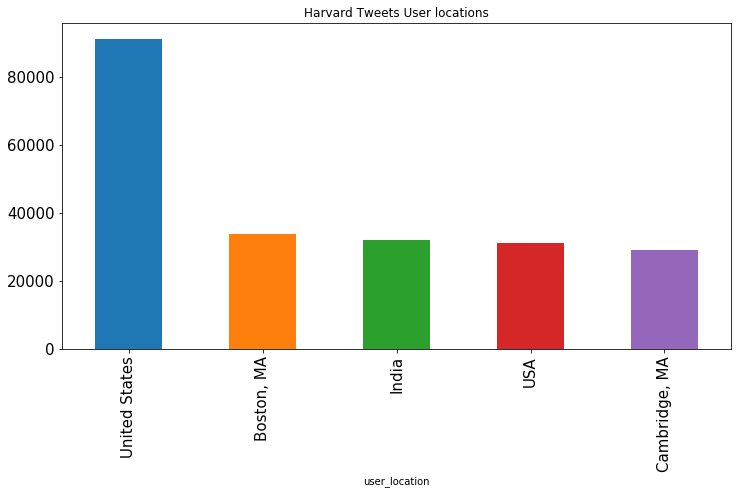

In [25]:
my_plot = tweets_df_columbia_userloc.plot(kind='bar',x='user_location', y='total_users_located', 
                                   legend=None, title="Harvard Tweets User locations",
                                   figsize=(12,6),fontsize=15)

### University of Pennsylvania

In [27]:
# UPenn users locations
tweets_df_upenn_userloc = tweets_df_upenn.filter(col('user_location').isNotNull()).\
groupBy(['user_location']).\
agg(count('user_id').alias('total_users_located')).orderBy('total_users_located',ascending=False).limit(5).toPandas()

# checking rows
tweets_df_upenn_userloc

,user_location,total_users_located
0,United States,25415
1,"Philadelphia, PA",18657
2,"State College, PA",15014
3,USA,8414
4,"Chicago, IL",8223


Let's visualize the relationship between **user locations** and **University of Pennsylvania location (Philadelphia, Pennsylvania)**

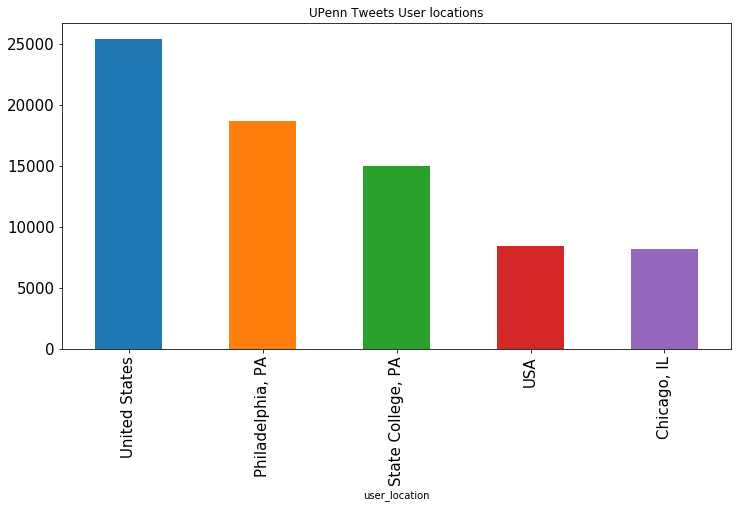

In [29]:
my_plot = tweets_df_upenn_userloc.plot(kind='bar',x='user_location', y='total_users_located', 
                                   legend=None, title="UPenn Tweets User locations",
                                   figsize=(12,6),fontsize=15)

## What distinguishes University of Chicago Twitterers vs Twitterers who tweet about other universities
- Visualize the trends

### Average followers count

In [31]:
d1 = {'university':['UChicago','Harvard','Columbia','UPenn'],
     'mean_user_followers_count':[tweets_df_uchicago.agg(round(mean('user_followers_count')).cast('integer')).toPandas().iloc[0].values[0],
                                 tweets_df_harvard.agg(round(mean('user_followers_count')).cast('integer')).toPandas().iloc[0].values[0],
                                 tweets_df_columbia.agg(round(mean('user_followers_count')).cast('integer')).toPandas().iloc[0].values[0],
                                 tweets_df_upenn.agg(round(mean('user_followers_count')).cast('integer')).toPandas().iloc[0].values[0]]}
univ_user_fol_count = pd.DataFrame(data=d1)
univ_user_fol_count

,university,mean_user_followers_count
0,UChicago,8520
1,Harvard,7271
2,Columbia,11335
3,UPenn,6787


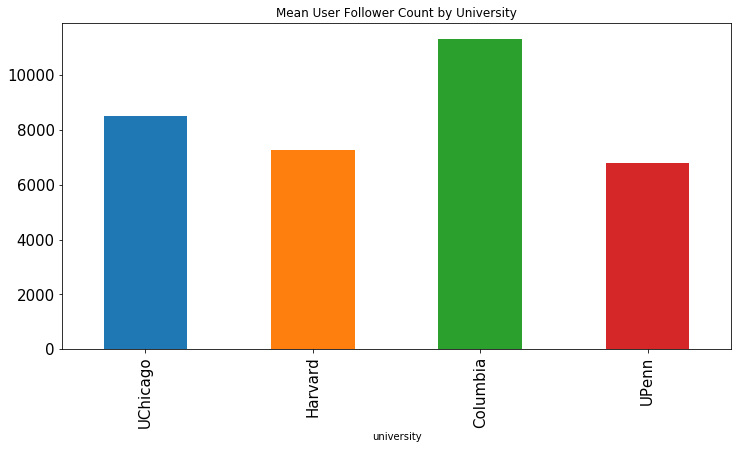

In [32]:
my_plot = univ_user_fol_count.plot(kind='bar',x='university', y='mean_user_followers_count', 
                                   legend=None, title="Mean User Follower Count by University",
                                   figsize=(12,6),fontsize=15)

### Average number of tweets (including retweets) issued by users

In [18]:
d4 = {'university':['UChicago','Harvard','Columbia','UPenn'],
     'mean_user_statuses_count':[tweets_df_uchicago.agg(round(mean('user_statuses_count')).cast('integer')).toPandas().iloc[0].values[0],
                                 tweets_df_harvard.agg(round(mean('user_statuses_count')).cast('integer')).toPandas().iloc[0].values[0],
                                 tweets_df_columbia.agg(round(mean('user_statuses_count')).cast('integer')).toPandas().iloc[0].values[0],
                                 tweets_df_upenn.agg(round(mean('user_statuses_count')).cast('integer')).toPandas().iloc[0].values[0]]}
univ_user_sttus_count = pd.DataFrame(data=d4)
univ_user_sttus_count

,university,mean_user_statuses_count
0,UChicago,41673
1,Harvard,40132
2,Columbia,49072
3,UPenn,43708


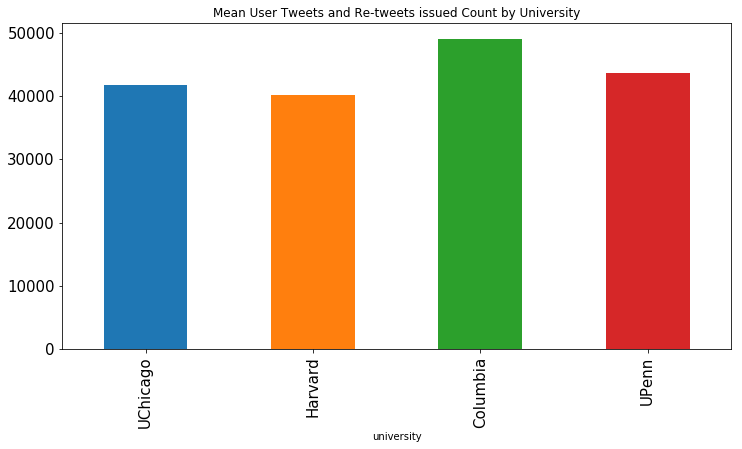

In [19]:
my_plot = univ_user_sttus_count.plot(kind='bar',x='university', y='mean_user_statuses_count', 
                                   legend=None, title="Mean User Tweets and Re-tweets issued Count by University",
                                   figsize=(12,6),fontsize=15)

## What are the timelines of these tweets? Do you see significant peaks and valleys?
- Do you see data collection gaps?

In [21]:
!hadoop fs -ls  -C  /user/ivy2/Tweets/ | head -10

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
/user/ivy2/Tweets/tweets201706221015.json
/user/ivy2/Tweets/tweets201706221115.json
/user/ivy2/Tweets/tweets201706221215.json
/user/ivy2/Tweets/tweets201706221315.json
/user/ivy2/Tweets/tweets201706221415.json
/user/ivy2/Tweets/tweets201706221515.json
/user/ivy2/Tweets/tweets201706221615.json
/user/ivy2/Tweets/tweets201706221715.json
/user/ivy2/Tweets/tweets201706221815.json
/user/ivy2/Tweets/tweets201706221915.json


The timelines for these tweets seems to be **hourly**. To check for any significant peaks and valleys, we can **aggregate the number of tweets** upon days or months or years or hours.

For checking the peaks and valleys, I chose to **aggregate** the number of tweets on a **monthly** basis.

In [22]:
# adding created month and year as separate columns for group by
tweets_new_df = tweets_new_df.\
withColumn('created_month',split('created_at',' ')[1]).\
withColumn('created_year',split('created_at',' ')[5])

In [23]:
# aggregating my month and year
tweet_count_timeline_df = tweets_new_df.groupby(['created_year','created_month']).\
agg(count('id_str').alias('total_tweets')).toPandas()

In [24]:
# separate df for respective years
tweet_count_timeline_df_2018 = tweet_count_timeline_df[tweet_count_timeline_df['created_year']=='2018'][['created_month','total_tweets']]
tweet_count_timeline_df_2019 = tweet_count_timeline_df[tweet_count_timeline_df['created_year']=='2019'][['created_month','total_tweets']]
tweet_count_timeline_df_2020 = tweet_count_timeline_df[tweet_count_timeline_df['created_year']=='2020'][['created_month','total_tweets']]

Text(0,0.5,'Number of Tweets')

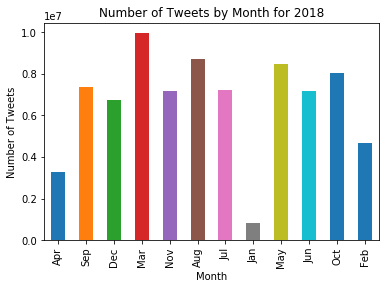

In [26]:
# plotting the results
my_plot1 = tweet_count_timeline_df_2018.plot(kind='bar',x='created_month',y='total_tweets',
                                        title="Number of Tweets by Month for 2018",legend=False)
my_plot1.set_xlabel('Month')
my_plot1.set_ylabel('Number of Tweets')

Text(0,0.5,'Number of Tweets')

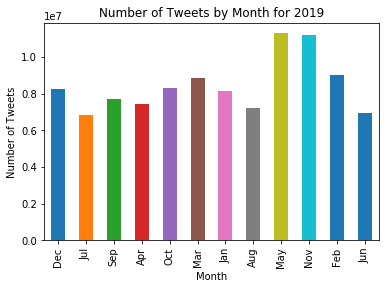

In [27]:
# plotting the results
my_plot1 = tweet_count_timeline_df_2019.plot(kind='bar',x='created_month',y='total_tweets',
                                        title="Number of Tweets by Month for 2019",legend=False)
my_plot1.set_xlabel('Month')
my_plot1.set_ylabel('Number of Tweets')

Text(0,0.5,'Number of Tweets')

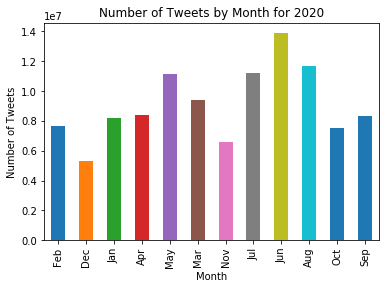

In [28]:
# plotting the results
my_plot1 = tweet_count_timeline_df_2020.plot(kind='bar',x='created_month',y='total_tweets',
                                        title="Number of Tweets by Month for 2020",legend=False)
my_plot1.set_xlabel('Month')
my_plot1.set_ylabel('Number of Tweets')

In [1]:
# checking the files
!hadoop fs -ls  -C  /user/ivy2/Tweets/ | head -10

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
/user/ivy2/Tweets/tweets201706221015.json
/user/ivy2/Tweets/tweets201706221115.json
/user/ivy2/Tweets/tweets201706221215.json
/user/ivy2/Tweets/tweets201706221315.json
/user/ivy2/Tweets/tweets201706221415.json
/user/ivy2/Tweets/tweets201706221515.json
/user/ivy2/Tweets/tweets201706221615.json
/user/ivy2/Tweets/tweets201706221715.json
/user/ivy2/Tweets/tweets201706221815.json
/user/ivy2/Tweets/tweets201706221915.json


In [2]:
# collecting all the file names in a list
tweets_file_names = !hdfs dfs -ls -d /user/ivy2/Tweets/* | awk '{print $8}'| while read fn; do basename $fn; done
tweets_file_names[0:10]

['WARNING: log4j.properties is not found. HADOOP_CONF_DIR may be incomplete.',
 'Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0',
 'tweets201706221015.json',
 'tweets201706221115.json',
 'tweets201706221215.json',
 'tweets201706221315.json',
 'tweets201706221415.json',
 'tweets201706221515.json',
 'tweets201706221615.json',
 'tweets201706221715.json']

In [3]:
# removing unwanted first 2 elements
tweets_file_names = tweets_file_names[2:]
tweets_file_names[:10]

['tweets201706221015.json',
 'tweets201706221115.json',
 'tweets201706221215.json',
 'tweets201706221315.json',
 'tweets201706221415.json',
 'tweets201706221515.json',
 'tweets201706221615.json',
 'tweets201706221715.json',
 'tweets201706221815.json',
 'tweets201706221915.json']

In [4]:
# removing unwanted characters from files names
tweets_file_names = [s.replace("tweets", "") for s in tweets_file_names]
tweets_file_names = [s.replace(".json", "") for s in tweets_file_names]
tweets_file_names[:10]

['201706221015',
 '201706221115',
 '201706221215',
 '201706221315',
 '201706221415',
 '201706221515',
 '201706221615',
 '201706221715',
 '201706221815',
 '201706221915']

Since its hourly data, data might be collected at **any minute of the hour**, we ignore the minute from filename

In [5]:
tweets_file_names = [s[0:10] for s in tweets_file_names]
tweets_file_names[:10]

['2017062210',
 '2017062211',
 '2017062212',
 '2017062213',
 '2017062214',
 '2017062215',
 '2017062216',
 '2017062217',
 '2017062218',
 '2017062219']

In [6]:
# finding end date
tweets_file_names[len(tweets_file_names)-1]

'2021031618'

In [17]:
# defining the function to generate hourly date time strings
def datetime_range(start, end, delta):
    current = start
    while current <= end:
        yield current
        current += delta

In [18]:
# generating the desired file names without gaps
desired_file_names = [dt.strftime('%Y%m%d%H') for dt in 
                      datetime_range(datetime(2017, 6, 22, 10), datetime(2021, 3, 16, 18), 
                      timedelta(hours=1))]

desired_file_names[-10:]

['2021031609',
 '2021031610',
 '2021031611',
 '2021031612',
 '2021031613',
 '2021031614',
 '2021031615',
 '2021031616',
 '2021031617',
 '2021031618']

In [21]:
print('Dates on which data not collected :')
for item in tweets_file_names:
    if item not in desired_file_names:
        print(item)

Dates on which data not collected :


**NO data collection gaps**.

## How unique are the messages for each of these universities?
- Are they mostly unique? Or mostly people are just copy-pasting the same text?
- You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
- Visualize message duplication (for each university – not between the universities)
- Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis.

We will use **Minhash LSH** to measure similarity of texts

### UChicago

In [15]:
uchicago_tweets_text = tweets_df_uchicago.select(['text']).limit(10000)

#### Remove stop words and create index

In [16]:
# removing the stopwords
text = uchicago_tweets_text.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [25]:
# creating the index
row = Row('text')
uchicago_tweets_text_df = text.map(row).zipWithIndex().toDF(['text','id'])

In [26]:
# creating the dataframe with text and id
df_tokens_uchicago = spark.createDataFrame(tokens, ["list_of_words",'id'])

# Drop records with no tokens
df_tokens_uchicago = df_tokens_uchicago.where(col('list_of_words').getItem(0).isNotNull())

#### Now, let's fit countvectorizer to create word features

In [27]:
# creating the features
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_uchicago = vectorize.fit(df_tokens_uchicago).transform(df_tokens_UChicago)

#### Now, lets fit MinHashLSH to create hash table

This will make our task of finding the near duplicate titles much faster and will be computationally very effective

In [28]:
# creating hash table
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model1 = mh.fit(df_vectorize_uchicago)
df_hashed_uchicago = mh.fit(df_vectorize_uchicago).transform(df_vectorize_uchicago)

# joining the hashed table with normal table
df_hashed_text_uchicago = uchicago_tweets_text_df.join(df_hashed_uchicago, "id", how = 'left')

#### Now, we establish similarity threshold and return near-duplicate tweets

To begin with, let's keep a low Jaccard distance of **0.3** and see if we can identify any similar tweets. We join dataframe to itself to get near duplicate pairs of tweets.

In [29]:
# setting a low Jaccard distance of 0.3
jaccard_distance = 0.3

# joining dataframe with itself
df_dups_text_uchicago = model1.approxSimilarityJoin(df_hashed_text_uchicago, df_hashed_text_uchicago, jaccard_distance).\
filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [30]:
# cheking first few near duplicate tweets
df_dups_text_uchicago.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,4519,7232,"(RT @natnac: Hey @UChicago, grad student workers provided the majority of my education, intellectual &amp; emotional support, and essentially su…,)","(RT @chicago_commune: Dumpster barricades in place at University of Chicago Police Department. Hundreds in the streets dancing and sharing f…,)"
1,0.0,2403,9343,"(@bfraser747 @rising_serpent Weird. Didn’t he supposedly teach Constitutional Law at University of Chicago? Maybe it… https://t.co/oyunir6BzX,)","(@uchicagogsu @UChicago Congrats!!!,)"
2,0.0,551,1700,"(UChicago's planned business major was scrapped after students spoke out against it, saying that a business major wo… https://t.co/02s1VCdhmx,)","(RT @mining_for_cole: Uchicago students taking a break from posting pictures of them holding their theses on the quad to post pictures of th…,)"
3,0.0,5847,6092,"(From our friends at UChicago @uchicago - Botany Pond is a popular on-campus housing option for ducks, four species… https://t.co/YKwumxfLH9,)","(RT @UChicagoHum: There are a few spots left for the #HumanitiesDay Public Art on Campus tour. Register today: https://t.co/Rv6nitqjqA https…,)"
4,0.0,6074,7346,"(RT @UChicagoArts: February is Black History Month. @LoganUChicago's current exhibition allows viewers a chance to experience black history…,)","(A University of Chicago study found 68% of unemployed workers who are eligible for benefits receive more in jobless… https://t.co/AfhWwdAu3t,)"


In [31]:
# checking the number of uniques and duplicates
records = df_hashed_text_UChicago.count()
dups = df_dups_text_UChicago.select('id_A').distinct().count()
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance, '} jaccard distance: ', uniques)

Total tweets:  10000
Duplicate tweets based on { 0.3 } jaccard distance:  3680
Unique tweets based on { 0.3 } jaccard distance:  6320


**visualization****

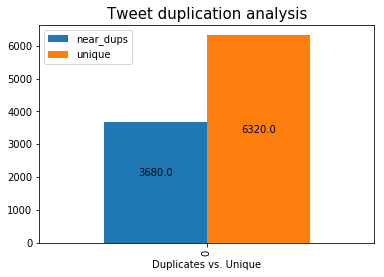

In [33]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8)
ax.set_title('Tweet duplication analysis', fontsize=15)
ax.set_xlabel('Duplicates vs. Unique')
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Columbia University

In [15]:
columbia_tweets_text = tweets_df_columbia.select(['text']).limit(10000)

In [16]:
# removing the stopwords
text = columbia_tweets_text.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [17]:
# creating the index
row = Row('text')
columbia_tweets_text_df = text.map(row).zipWithIndex().toDF(['text','id'])

In [18]:
# creating the dataframe with text and id
df_tokens_columbia = spark.createDataFrame(tokens, ["list_of_words",'id'])

# Drop records with no tokens
df_tokens_columbia = df_tokens_columbia.where(col('list_of_words').getItem(0).isNotNull())

In [19]:
# creating the features
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_columbia = vectorize.fit(df_tokens_columbia).transform(df_tokens_columbia)

In [20]:
# creating hash table
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model2 = mh.fit(df_vectorize_columbia)
df_hashed_columbia = mh.fit(df_vectorize_columbia).transform(df_vectorize_columbia)

# joining the hashed table with normal table
df_hashed_text_columbia = columbia_tweets_text_df.join(df_hashed_columbia, "id", how = 'left')

In [21]:
# setting a low Jaccard distance of 0.3
jaccard_distance = 0.3

# joining dataframe with itself
df_dups_text_columbia = model2.approxSimilarityJoin(df_hashed_text_columbia, df_hashed_text_columbia, jaccard_distance).\
filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [22]:
# checking the number of uniques and duplicates
records = df_hashed_text_columbia.count()
dups = df_dups_text_columbia.select('id_A').distinct().count()
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance, '} jaccard distance: ', uniques)

Total tweets:  10000
Duplicate tweets based on { 0.3 } jaccard distance:  6127
Unique tweets based on { 0.3 } jaccard distance:  3873


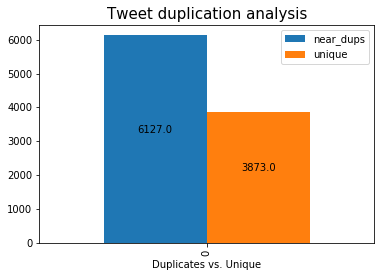

In [23]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8)
ax.set_title('Tweet duplication analysis', fontsize=15)
ax.set_xlabel('Duplicates vs. Unique')
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

### Harvard University

In [25]:
harvard_tweets_text = tweets_df_harvard.select(['text']).limit(10000)

In [26]:
# removing the stopwords
text = harvard_tweets_text.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [27]:
# creating the index
row = Row('text')
harvard_tweets_text_df = text.map(row).zipWithIndex().toDF(['text','id'])

In [28]:
# creating the dataframe with text and id
df_tokens_harvard = spark.createDataFrame(tokens, ["list_of_words",'id'])

# Drop records with no tokens
df_tokens_harvard = df_tokens_harvard.where(col('list_of_words').getItem(0).isNotNull())

In [29]:
# creating the features
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize_harvard = vectorize.fit(df_tokens_harvard).transform(df_tokens_harvard)

In [30]:
# creating hash table
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model3 = mh.fit(df_vectorize_harvard)
df_hashed_harvard = mh.fit(df_vectorize_harvard).transform(df_vectorize_harvard)

# joining the hashed table with normal table
df_hashed_text_harvard = harvard_tweets_text_df.join(df_hashed_harvard, "id", how = 'left')

In [31]:
# setting a low Jaccard distance of 0.3
jaccard_distance = 0.3

# joining dataframe with itself
df_dups_text_harvard = model3.approxSimilarityJoin(df_hashed_text_harvard, df_hashed_text_harvard, jaccard_distance).\
filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
            )

In [32]:
# checking the number of uniques and duplicates
records = df_hashed_text_harvard.count()
dups = df_dups_text_harvard.select('id_A').distinct().count()
uniques = records - dups

print ('Total tweets: ', records)
print ('Duplicate tweets based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance, '} jaccard distance: ', uniques)

Total tweets:  10000
Duplicate tweets based on { 0.3 } jaccard distance:  4533
Unique tweets based on { 0.3 } jaccard distance:  5467


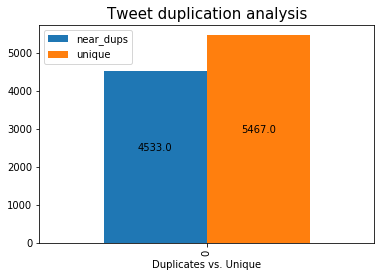

In [33]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8)
ax.set_title('Tweet duplication analysis', fontsize=15)
ax.set_xlabel('Duplicates vs. Unique')
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 